# 导入包

In [22]:
import os
import sys

In [23]:
import os
import time
import matplotlib.pyplot as plt
import torch
import torchvision

In [24]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Please set GPU via Edit -> Notebook Settings.")
    DEVICE = torch.device("cpu")
DTYPE = torch.float32

Good to go!


## Load NeRF Data

First we download data for two example datasets: `LEGO` and `FERN`, which are provided on [NeRF website](https://www.matthewtancik.com/nerf).

加载 NeRF 所需的数据

Data loading functions are implemented in data_loader.py, including blender data loader (for `LEGO`) and llff data loader (for `FERN`).

We load `LEGO` data and visualize one sample image below. 

In [25]:
from data_loader import load_blender_data
dataset_path = "./"
LEGO_DIR = os.path.join(dataset_path, "data", "nerf_synthetic", "lego")
LEGO_DIR

'./data\\nerf_synthetic\\lego'

In [26]:
# reduce the image resolution by dev_res, e.g. 800->100 pixels
# note that Google Colab environment provide 16GB GPU RAM, which limits our resolution to about 200*200
dev_res = 4

# load part of the whole dataset 
# no skip for train (100), 100/skip for val, 200/skip for test
skip = 4

images, poses, hwf, i_split = load_blender_data(LEGO_DIR, dev_res, skip, device=DEVICE)
H, W, focal_length = hwf

Images shape:  (175, 200, 200, 4)
Poses shape:  (175, 4, 4)


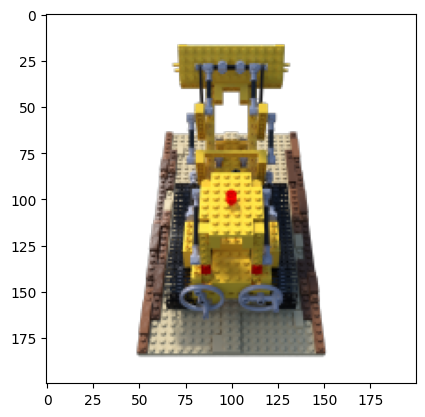

In [27]:
# show the first test image
plt.imshow(images[len(i_split[0])+len(i_split[1])].detach().cpu().numpy())
plt.show()

#Rays Function

#### Get a bundle of rays.

Here we define a function, which takes the height & width of the image, focal length and transformation matrix (camera pose) as input. The function outputs a set of origin points and direction vectors, which could be used to describe rays shooting out from image pixels.

In [28]:
from NeRF import get_rays
ray_origins, ray_directions = get_rays(H, W, focal_length, poses[1])
print(ray_origins.shape, ray_directions.shape)
print(ray_origins.device, ray_origins.dtype)

torch.Size([200, 200, 3]) torch.Size([200, 200, 3])
cuda:0 torch.float32


In [29]:
print(ray_directions[0][0])

tensor([ 0.7241, -0.8570,  0.0214], device='cuda:0')


#### Sample a set of 3D points given the bundle of rays.

During volumn rendering, the original paper states that the color observed by the camera could be calculated by volume rendering equation, which get the integral along the rays. In order to speed up the calculation, we approximate integrals with a set of sampled 3D points on the rays.

We assume that a _near_ and a _far_ clipping distance are provided that delineate the volume of interest. Each ray is evaluated only within these bounds. Then we sample 3D points along each ray.

In [30]:
num_samples = 4
near_point = 2
far_point = 6

In [31]:
from NeRF import sample_points_from_rays
sampled_points, depth_values = sample_points_from_rays(
                                 ray_origins,
                                 ray_directions,
                                 near_point=near_point,
                                 far_point=far_point,
                                 num_samples=num_samples,
                                 random=True
                               )
print(depth_values.shape)
print(sampled_points.shape)
print(sampled_points[0][0])

torch.Size([200, 200, 4])
torch.Size([200, 200, 4, 3])
tensor([[ 0.2211,  1.6373,  1.3367],
        [ 1.2947,  0.3667,  1.3684],
        [ 2.1796, -0.6806,  1.3945],
        [ 3.4427, -2.1755,  1.4318]], device='cuda:0')


# Positional Encoding

In [32]:
from NeRF import positional_encoding
flattened_sampled_points = sampled_points.reshape((-1, 3))
pos_out = positional_encoding(flattened_sampled_points, 3)

# Tiny NeRF Model

In [33]:
from NeRF import TinyNeRF
pos_dim = pos_out.shape[-1]
model = TinyNeRF(pos_dim, fc_dim=128)
model.cuda()

TinyNeRF(
  (nerf): Sequential(
    (0): Linear(in_features=21, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=4, bias=True)
  )
)

#Volumn Rendering

We feed the x,y,z coordinate to out tiny NeRF model, which consists of fully connected layer. The model forward returns predicted RGB color and predicted volume density for each sampled point on the rays.

In [34]:
radiance_field = model(pos_out)
radiance_field = radiance_field.view(H, W, num_samples, 4)

In [35]:
print(radiance_field[0][0])

tensor([[-0.0366,  0.0203,  0.0976, -0.0444],
        [-0.0476,  0.0547,  0.0982, -0.0208],
        [-0.0630,  0.0396,  0.0544, -0.0426],
        [-0.0800, -0.0070,  0.0526, -0.0459]], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [36]:
from NeRF import volume_rendering
rgb_map, depth_map, acc_map = volume_rendering(radiance_field, ray_origins, depth_values)

# Train

Loss: 0.17076511681079865


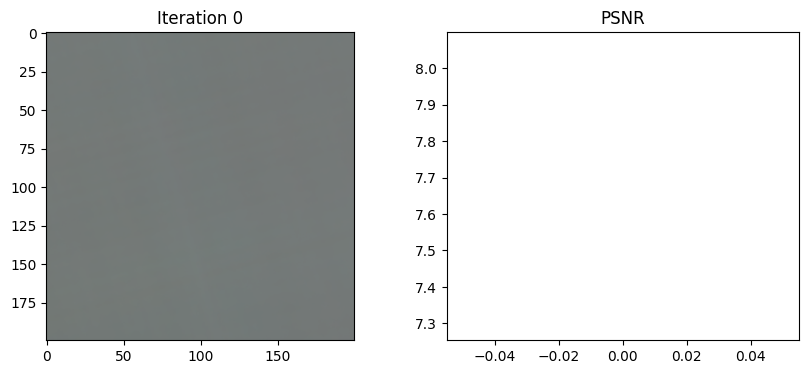

Loss: 0.02399475872516632


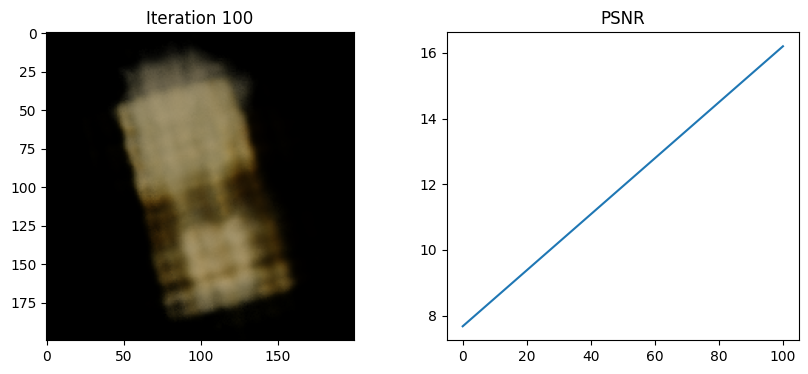

Loss: 0.01232060045003891


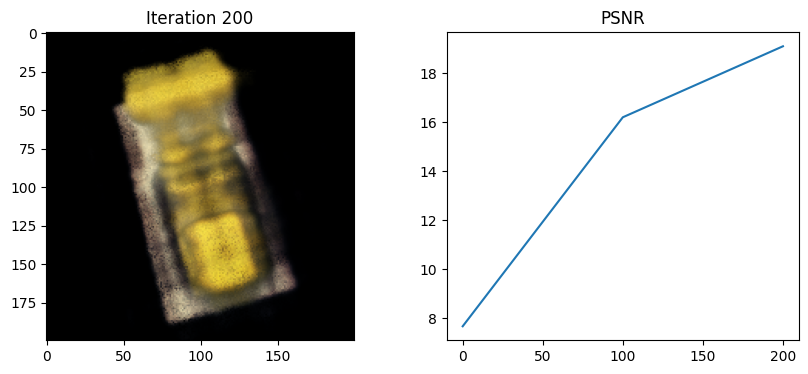

Loss: 0.011589817702770233


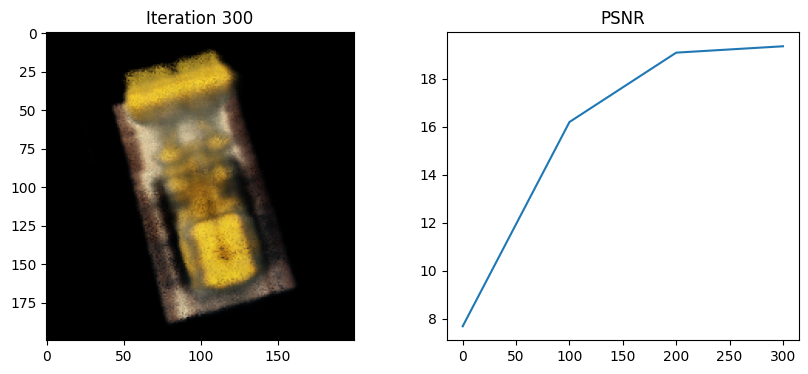

Loss: 0.012829335406422615


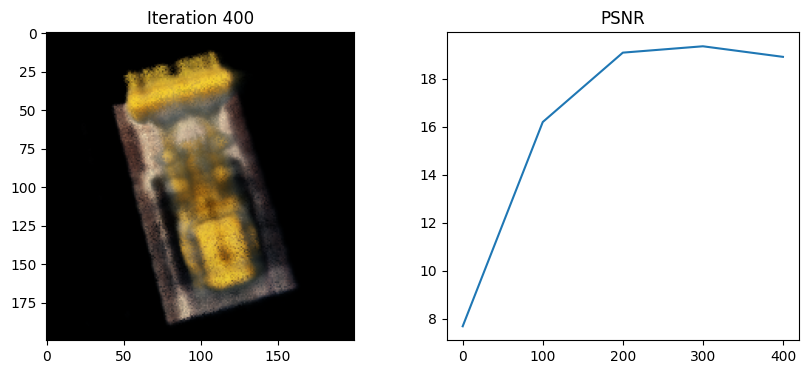

Loss: 0.008439244702458382


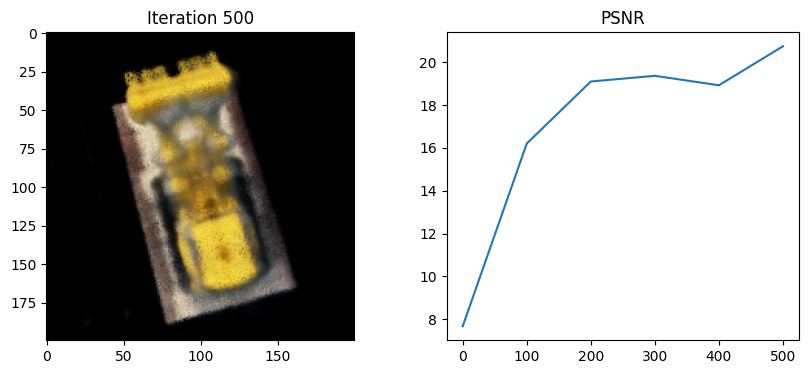

Loss: 0.00866551324725151


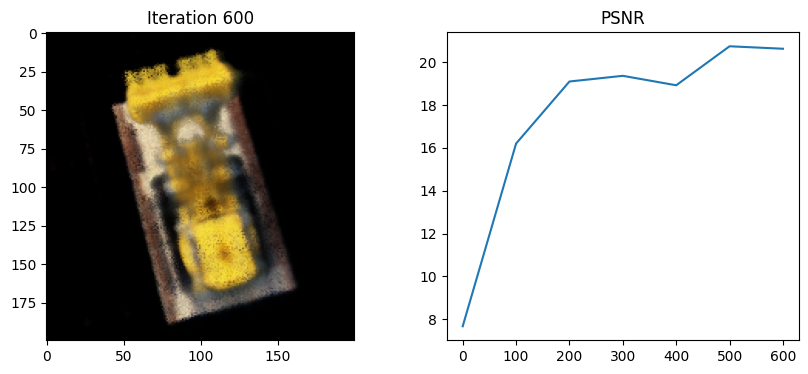

Loss: 0.008161760866641998


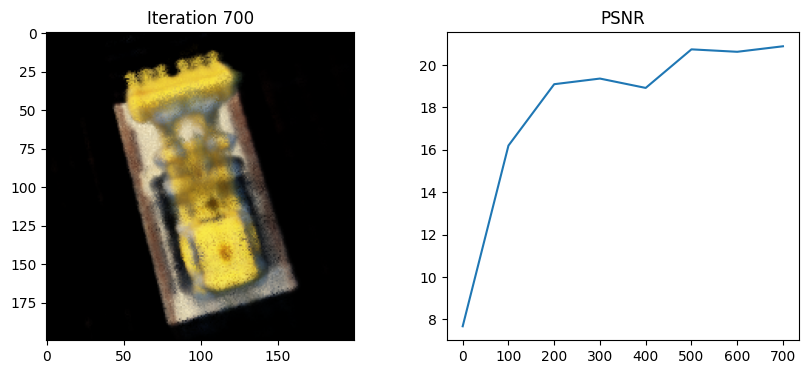

Loss: 0.007898403331637383


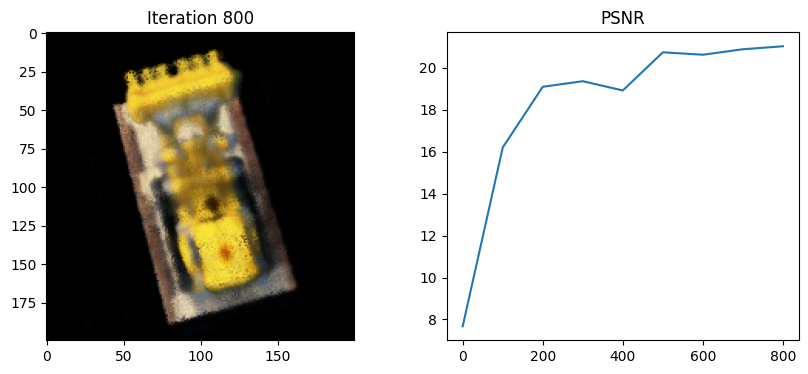

Loss: 0.007941505871713161


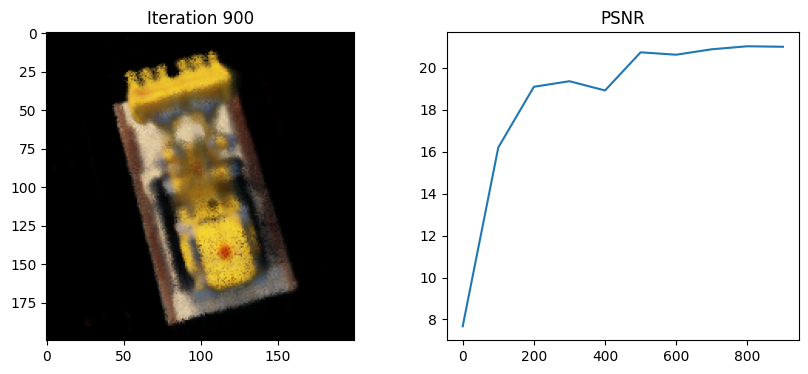

Loss: 0.007600944954901934


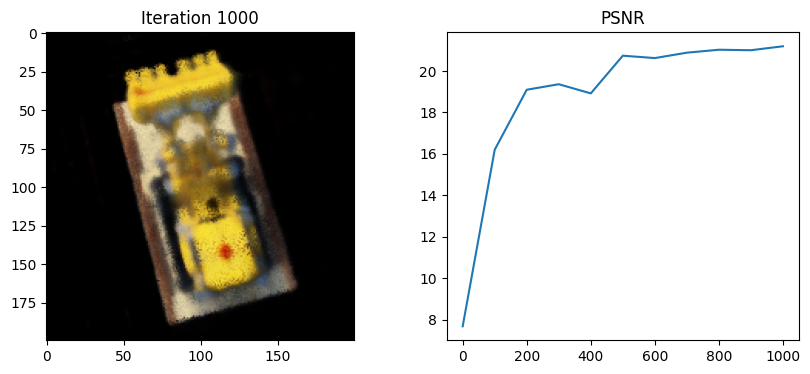

Loss: 0.007087894715368748


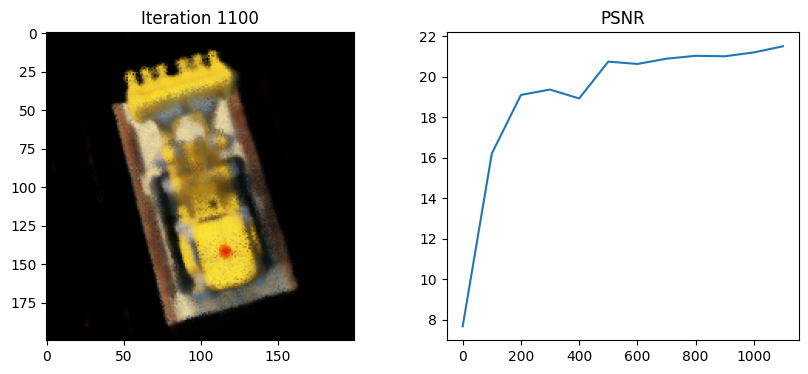

Loss: 0.006552180275321007


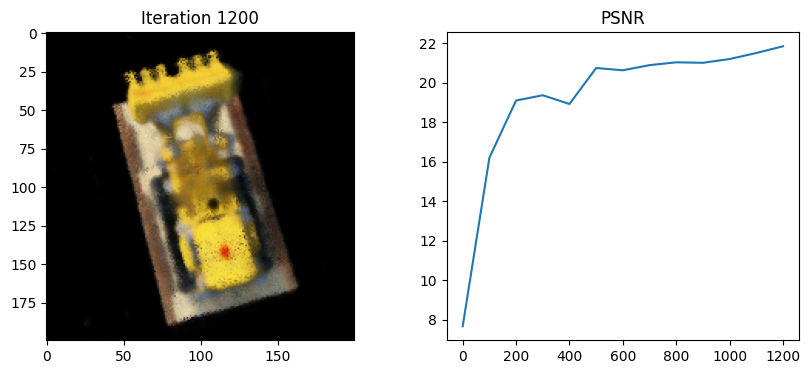

Loss: 0.0067241862416267395


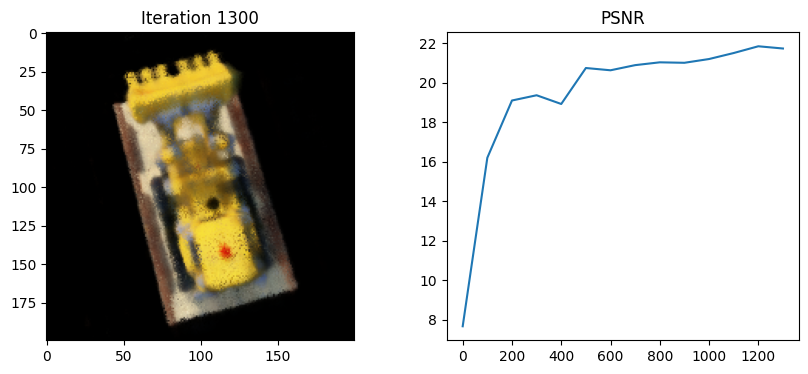

Loss: 0.006055318284779787


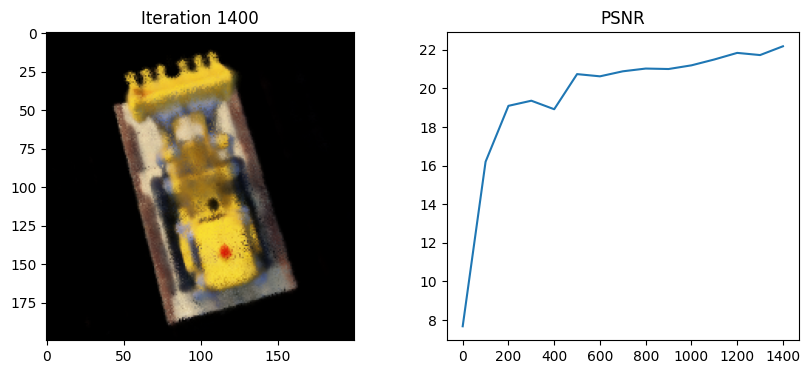

Loss: 0.006730473600327969


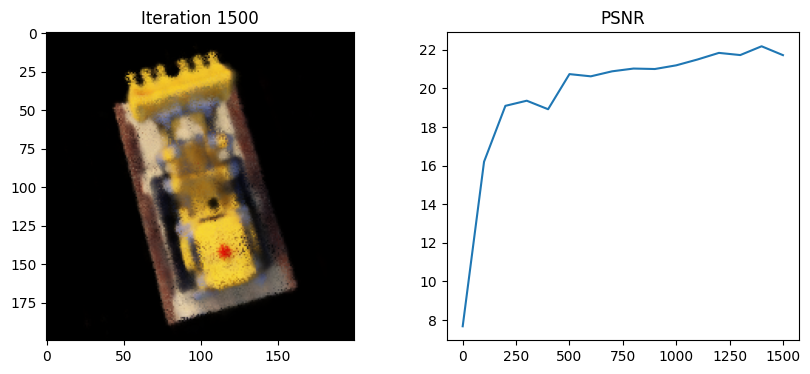

Loss: 0.006892357487231493


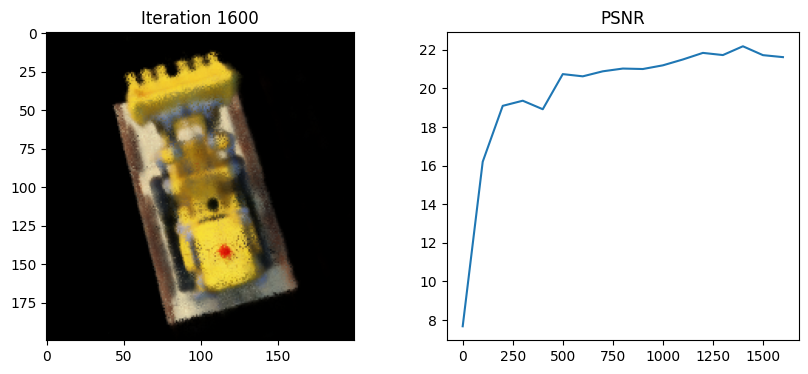

Loss: 0.005604216363281012


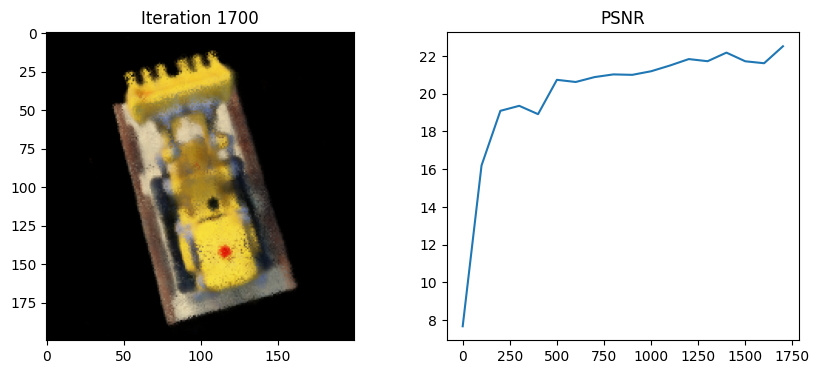

Loss: 0.005703409668058157


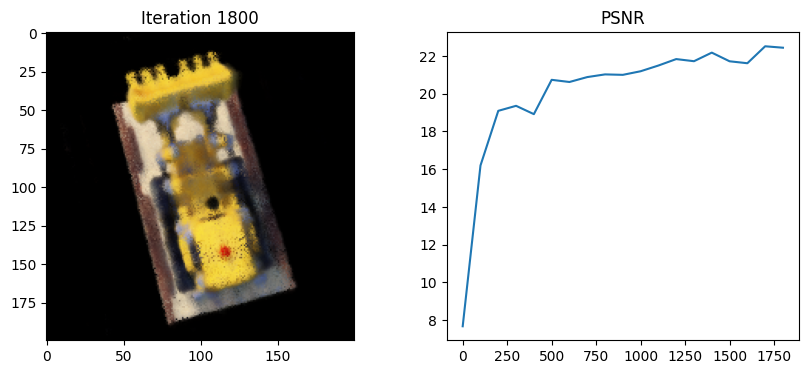

Loss: 0.0067662703804671764


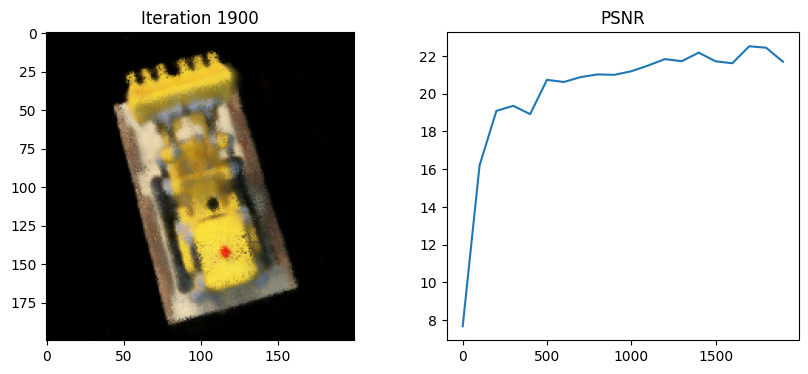

Finish training


In [37]:
from NeRF import train
from NeRF import tinynerf_step_forward

# Near and far clipping distance
near_point = 2
far_point = 6

# Encoder definition, we use positional encoding
freq = 6
include_input = True
encoder = lambda x: positional_encoding(x, include_input=include_input, freq=freq)
enc_dim = (include_input + 2 *freq) * 3

# Define a tinynerf model, feel free to change the `fc_dim`
model = TinyNeRF(enc_dim, fc_dim=128)
model.cuda()

# Number of depth samples along each ray.
num_depth_samples_per_ray = 64

num_iters = 2000
train(images, poses, hwf, i_split, near_point,
      far_point, num_depth_samples_per_ray, encoder, 
      num_iters, model)

# Render 360 Video

In [38]:
import numpy as np
from NeRF import tinynerf_step_forward
from NeRF import get_minibatches
from tqdm import tqdm_notebook as tqdm

trans_t = lambda t : torch.tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=torch.float32)

rot_phi = lambda phi : torch.tensor([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1],
], dtype=torch.float32)

rot_theta = lambda th : torch.tensor([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1],
], dtype=torch.float32)

def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    tmp = torch.tensor([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]).to(dtype=torch.float32)
    c2w = tmp @ c2w
    return c2w

frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.).to(device="cuda")
    rays_o, rays_d = get_rays(H, W, focal_length, c2w[:3,:4])
    rgb = tinynerf_step_forward(H, W, focal_length,
                                            c2w, 2, 6, 64, encoder,
                                            get_minibatches, model)
    rgb = rgb.detach().cpu().numpy()
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

C:\Users\xiangjinhui\AppData\Local\conda\conda\envs\nerf-torch\lib\site-packages\ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/120 [00:00<?, ?it/s]

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 200) to (208, 208) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [39]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [40]:
torch.cuda.empty_cache()

In [21]:
import mindspore
pos_in = [1,2,3]
pos_out = [pos_in]
freq = 10
if True:
    # freq_bands = 2.0 ** torch.linspace(0.0, freq - 1, freq).to(pos_in)
    start = mindspore.Tensor(0,mindspore.float32)
    stop = mindspore.Tensor(9,mindspore.float32)
    num = mindspore.Tensor(10,mindspore.int32)
    freq_bands = 2 ** mindspore.ops.LinSpace(start, stop, num)
    freq_bands.to(pos_in)
else:
    freq_bands = mindspore.ops.LinSpace(2.0 ** 0.0, 2.0 ** (freq - 1), freq).to(pos_in)
    # freq_bands = torch.linspace(2.0 ** 0.0, 2.0 ** (freq - 1), freq).to(pos_in)

# TODO: why reduce \pi when calculating sin and cos
for freq in freq_bands:
    for func in [mindspore.ops.Sin, mindspore.ops.Cos]:
    # for func in [torch.sin, torch.cos]:
        pos_out.append(func(pos_in * freq))
print(pos_out)
# pos_out = torch.cat(pos_out, dim=-1)

TypeError: too many positional arguments

In [23]:
start = mindspore.Tensor(1.0,mindspore.float32)
end = mindspore.Tensor(10,mindspore.float32)
num = mindspore.Tensor(10,mindspore.int32)
pos_in = mindspore.Tensor(13)
freq_bands = 2 ** mindspore.ops.linspace(start,end,num)
freq_bands.to(pos_in)

AttributeError: 'Tensor' object has no attribute 'to'

In [1]:
import mindspore


In [3]:
H = 200
W = 200

In [14]:
W = mindspore.Tensor(200,dtype=mindspore.int32)
start = mindspore.Tensor(0,dtype=mindspore.int32)
i = mindspore.numpy.linspace(start,W-1,200)

In [17]:
i

Tensor(shape=[200], dtype=Float32, value= [0.00000000e+000, 1.00000000e+000, 2.00000000e+000, 3.00000000e+000, 4.00000000e+000, 5.00000000e+000, 6.00000000e+000, 7.00000000e+000, 8.00000000e+000, 9.00000000e+000, 1.00000000e+001, 1.10000000e+001, 
 1.20000000e+001, 1.30000000e+001, 1.40000000e+001, 1.50000000e+001, 1.60000000e+001, 1.70000000e+001, 1.80000000e+001, 1.90000000e+001, 2.00000000e+001, 2.10000000e+001, 2.20000000e+001, 2.30000000e+001, 
 2.40000000e+001, 2.50000000e+001, 2.60000000e+001, 2.70000000e+001, 2.80000000e+001, 2.90000000e+001, 3.00000000e+001, 3.10000000e+001, 3.20000000e+001, 3.30000000e+001, 3.40000000e+001, 3.50000000e+001, 
 3.60000000e+001, 3.70000000e+001, 3.80000000e+001, 3.90000000e+001, 4.00000000e+001, 4.10000000e+001, 4.20000000e+001, 4.30000000e+001, 4.40000000e+001, 4.50000000e+001, 4.60000000e+001, 4.70000000e+001, 
 4.80000000e+001, 4.90000000e+001, 5.00000000e+001, 5.10000000e+001, 5.20000000e+001, 5.30000000e+001, 5.40000000e+001, 5.50000000e+00